#### Introduction: Final Project

#### Group: Josh Forster & Ben Inbar

The final project prompt is fairly open-ended and the main premise of the assignment is to demonstrate a thorough  analysis of a dataset that has network components as well as potential text analysis via NLP methods learned throughout the course. Although these two topic areas diverge in some respect we were able to identify a publicly available Wayfair [dataset](https://github.com/wayfair/WANDS/blob/main/README.md) that lists common product queries on their platform and provides an annotated classificaiton of the result relevancy. In this way, there are several areas that we intend to explore through this workbook:

- Build a bipartite network where nodes are queries and products, and then produce a projection of products, potentially applying a weighting of normalized/factorized label, or average rating, or number of queries.
- Perform PageRank comparison against the provided labels to evaluate the probabilities of a search given a random customer. Further layering in some product information to determine likelihood of certain categories.
- Perform sentiment analysis on the product descriptions provided by the vendors to assess if sentiment correlates with search results positioning, potentially for comparison with customer ratings or number of queries.


#### Load Relevant Libraries

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import re
import json
import math
import seaborn as sns

In [2]:
labels = 'https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/label.csv'
products = 'https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/product.csv'
queries = 'https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/query.csv'

#### Loading Labeled Dataset

This contains 233,448 manually input 'relevance' judgements (denoted under `label`) for each product that is returned in a total of 480 queries (denoted under `query_id`).

In [3]:
label_df = pd.read_csv(labels,delimiter='\t')
label_df.head()

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact


In [4]:
print(label_df.dtypes, label_df.shape)

id             int64
query_id       int64
product_id     int64
label         object
dtype: object (233448, 4)


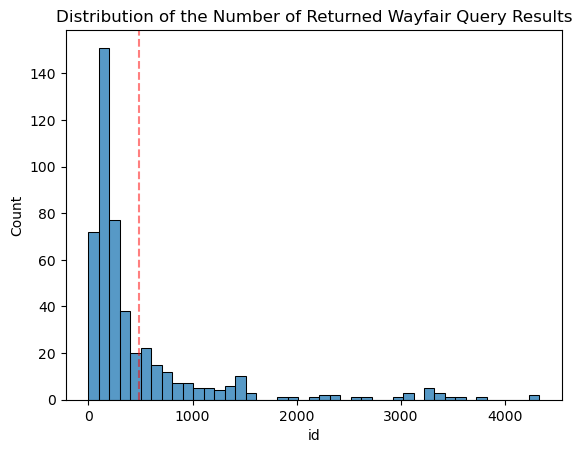

In [5]:
grouped_query_df = label_df.groupby('query_id')['id'].count()
sns.histplot(grouped_query_df).set_title('Distribution of the Number of Returned Wayfair Query Results')
plt.axvline(grouped_query_df.mean(), 0,150,linestyle='--',color='red',alpha=0.5)
plt.show();

The distribution of the query results actually varies quite a bit more than anticipated with a heavy right skew, which would lead to the hypothesis that the terms themselves may have a relationship with the number of results provided. One additional data point to blend in would be the number of terms in the search to see how that impacts the number of results. 

It is fairly surprising that a query could return over 1000 results, but that likely speaks to the popularity and breadth of certain products. Given that the mean count is approximately 500 it would seem as though certain products may have substantial variety in general. 

On the low end, it's possible that perhaps the searches cannot be clearly inferred, but additional review will need to be conducted.

#### Loading query dataset

Here, the actual queries themselves are shown, listing the search terms, the number of terms, and the category to which the query falls under.

In [6]:
query_df = pd.read_csv(queries,delimiter='\t')
query_df['number_of_terms'] = query_df['query'].apply(lambda words: len([word for word in words.split()]))
query_df.head()

,query_id,query,query_class,number_of_terms
0,0,salon chair,Massage Chairs,2
1,1,smart coffee table,Coffee & Cocktail Tables,3
2,2,dinosaur,Kids Wall Décor,1
3,3,turquoise pillows,Accent Pillows,2
4,4,chair and a half recliner,Recliners,5


In [7]:
query_df['number_of_terms'].describe()

count    480.000000
mean       3.381250
std        1.495457
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       10.000000
Name: number_of_terms, dtype: float64

In [8]:
print(query_df.dtypes,query_df.shape)

query_id            int64
query              object
query_class        object
number_of_terms     int64
dtype: object (480, 4)


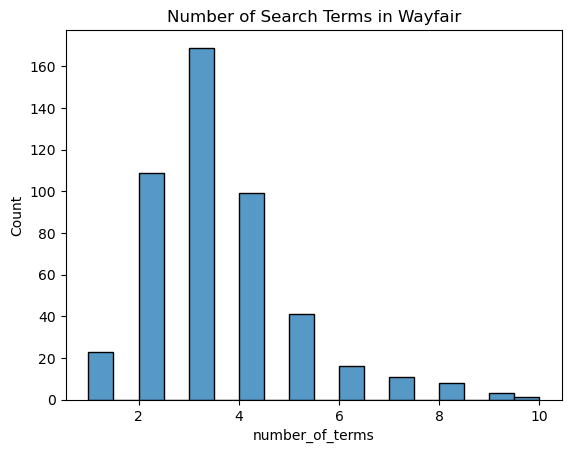

In [9]:
num_terms = query_df.groupby('number_of_terms')['query'].count().reset_index()
num_terms.rename(columns={'query':'count'},inplace=True)

sns.histplot(x='number_of_terms',data=query_df).set_title('Number of Search Terms in Wayfair')
plt.show();

The shape of the dataset appears to be approximately normal aside from a minor skew to the right above 6 terms. This makes sense intuitively, where people attempt to refine their search using more terms.

#### Merge the labels and queries

In [10]:
label_query_df = pd.merge(label_df,query_df,how='inner',on='query_id')
label_query_df = pd.merge(label_query_df,grouped_query_df,how='inner',left_on='query_id',right_index=True)
label_query_df.rename(columns={'id_y':'number_of_results'},inplace=True)
label_query_df.head()

,id_x,query_id,product_id,label,query,query_class,number_of_terms,number_of_results
0,0,0,25434,Exact,salon chair,Massage Chairs,2,3303
1,1,0,12088,Irrelevant,salon chair,Massage Chairs,2,3303
2,2,0,42931,Exact,salon chair,Massage Chairs,2,3303
3,3,0,2636,Exact,salon chair,Massage Chairs,2,3303
4,4,0,42923,Exact,salon chair,Massage Chairs,2,3303


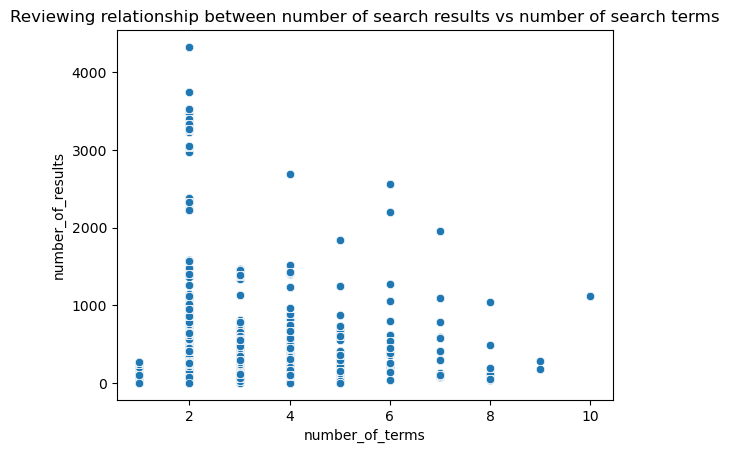

In [11]:
sns.scatterplot(x='number_of_terms',y='number_of_results',data=label_query_df).set_title('Reviewing relationship between number of search results vs number of search terms')
plt.show();

There is not a clear relationship between the number of search terms versus search results, with a possible slight negative linear pattern, favoring fewer terms in number of results returned.

#### Calculating Pearson Correlation Coefficient

Confirming the visual review of the scatterplot.

In [12]:
label_query_df['number_of_terms'].corr(label_query_df['number_of_results'])

-0.3585317151200877

#### Finally, load the products dataset

In this csv, we get useful information about each product, as well as product descriptions, features, and ratings.

In [13]:
product_df = pd.read_csv(products,delimiter='\t')
product_df.head()

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [14]:
(product_df.dtypes,product_df.shape)

(product_id               int64
 product_name            object
 product_class           object
 category hierarchy      object
 product_description     object
 product_features        object
 rating_count           float64
 average_rating         float64
 review_count           float64
 dtype: object,
 (42994, 9))

In [15]:
product_df.describe()

,product_id,rating_count,average_rating,review_count
count,42994.000000,33542.000000,33542.000000,33542.000000
mean,21496.500000,430.270437,4.530126,284.250343
std,12411.443073,2407.921579,0.509263,1539.611737
min,0.000000,1.000000,1.000000,0.000000
25%,10748.250000,8.000000,4.500000,6.000000
50%,21496.500000,42.000000,4.500000,31.000000
75%,32244.750000,195.000000,5.000000,131.000000
max,42993.000000,109226.000000,5.000000,61362.000000


In [16]:
product_df.isnull().sum()

product_id                0
product_name              0
product_class          2852
category hierarchy     1556
product_description    6008
product_features          0
rating_count           9452
average_rating         9452
review_count           9452
dtype: int64

There are some null values in the product dataset that may need to be handled in the network analysis.

Most products at Wayfair have only a few hundred or fewer ratings, with the exception of a very few who have as many as 1000-8000+ ratings.

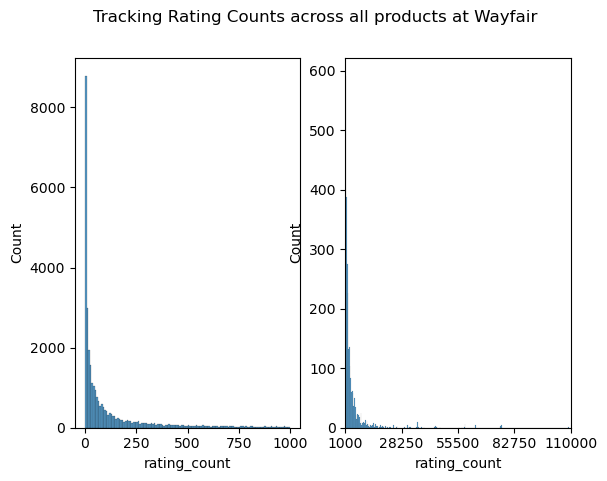

In [17]:
fig, ax = plt.subplots(1,2)
sns.histplot(x='rating_count',data=product_df[product_df['rating_count']<1000], ax=ax[0])
sns.histplot(x='rating_count',data=product_df[product_df['rating_count']>1000], ax=ax[1])
ax[1].set_xlim(5000,110000)
ax[1].set_xticks(np.linspace(1000,110000,5))
fig.suptitle('Tracking Rating Counts across all products at Wayfair')
#sns.histplot(x='rating_count',data=product_df[(product_df['rating_count']>1000)& (product_df['rating_count']>1000)], ax=ax[1])
plt.show();

In [18]:
full_df = pd.merge(label_query_df,product_df,how='inner',on='product_id')
print(full_df.shape)
full_df.head()

(233448, 16)


,id_x,query_id,product_id,label,query,query_class,number_of_terms,number_of_results,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,0,25434,Exact,salon chair,Massage Chairs,2,3303,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
1,68634,26,25434,Exact,leather chairs,Accent Chairs,2,3748,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
2,85371,131,25434,Partial,kids chair,Kids Chairs,2,3479,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
3,90015,151,25434,Partial,leather chair,Accent Chairs,2,3042,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
4,91500,152,25434,Partial,wishbone chair,Dining Chairs,2,3288,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN


#### Sentiment analysis of product descriptions.

Here, we'll tokenize the product descriptions and assign a polarity score using NLTK's VADER pre-trained sentiment analyzer. We'll of course have to do a little cleaning, i.e. break down each product description to clean it of non-word characters.

After that, we'll perform some basic part-of-speech tagging to get counts of major speech parts i.e. number of adverbs, adjectives, verbs, etc. before finalizing our dataframe with average customer ratings.

In [19]:
import nltk
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

pull = [descr for descr in product_df["product_description"]]
pull_clean = ['None' if descr is np.nan else descr for descr in pull]
words = [nltk.word_tokenize(item) for item in pull_clean]
words[0][:20]

['good',
 ',',
 'deep',
 'sleep',
 'can',
 'be',
 'quite',
 'difficult',
 'to',
 'have',
 'in',
 'this',
 'busy',
 'age',
 '.',
 'fortunately',
 ',',
 'there',
 '’',
 's']

In [20]:
for wordset in words:
    for word in wordset:
        if word.isalpha():
            pass
        else:
            wordset.remove(word)
            
words[0][:20]

['good',
 'deep',
 'sleep',
 'can',
 'be',
 'quite',
 'difficult',
 'to',
 'have',
 'in',
 'this',
 'busy',
 'age',
 'fortunately',
 'there',
 's',
 'an',
 'antidote',
 'to',
 'such']

In [21]:
final = []
for wordsets in words:
    rejoined = ' '.join(wordsets)
    final.append(rejoined)
    
final[0]

'good deep sleep can be quite difficult to have in this busy age fortunately there s an antidote to such a problem a nice quality bed frame like the acacia kaylin solidly constructed from acacia wood this bed frame will stand the test of time and is fit to rest your shoulders on for years and years its sleek natural wood grain appearance provides a pleasant aesthetic to adorn any bedroom acting both as a decorative piece as well as a place to give comfort after a hard day of work our bed frame is designed to give ample space for easy cleaning and other usages with a headboard attached to further express the craftiness it can be used with other accessories such as a nightstand or bookcase headboard and is compatible with many types of mattresses including memory foam spring or hybrid ones there s nowhere better to relax than your own home and with this bed frame that feeling of homeliness will even be more emphasized rest comfortably and in style'

Polarity scores on each product description using VADER.

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

sentiment_df = pd.DataFrame(columns=['neg', 'neu', 'pos', 'compound'])

for idx, descr in enumerate(final):
    polarity_dict = pd.DataFrame(sia.polarity_scores(descr), index=[idx])
    sentiment_df = pd.concat([sentiment_df, polarity_dict])
    
sentiment_df

,neg,neu,pos,compound
0,0.062,0.776,0.162,0.9498
1,0.027,0.858,0.114,0.9032
2,0.000,1.000,0.000,0.0000
3,0.068,0.779,0.153,0.3818
4,0.000,0.818,0.182,0.9042
...,...,...,...,...
42989,0.069,0.734,0.197,0.8481
42990,0.000,1.000,0.000,0.0000
42991,0.000,0.788,0.212,0.9769
42992,0.021,0.791,0.188,0.8625


Parts of speech tagging, and pulling counts of major tagged word types.

In [23]:
pos_df = pd.DataFrame(columns=['adjectives', 'nouns', 'pronouns', 'adverbs', 'verbs'])

z = words
x = nltk.pos_tag_sents(z)
    
for idx, tagged_word_list in enumerate(x):
    pos_df.loc[idx] = [0, 0, 0, 0, 0]
    for word_tups in tagged_word_list:
        if word_tups[1] in ['JJ', 'JJR', 'JJS']:
            pos_df.at[idx, 'adjectives'] += 1
        elif word_tups[1] in ['NN', 'NNP', 'NNPS', 'NNS']:
            pos_df.at[idx, 'nouns'] += 1
        elif word_tups[1] in ['PRP', 'PRP$']:
            pos_df.at[idx, 'pronouns'] += 1
        elif word_tups[1] in ['RB', 'RBR', 'RBS']:
            pos_df.at[idx, 'adverbs'] += 1
        elif word_tups[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            pos_df.at[idx, 'verbs'] += 1

pos_df

,adjectives,nouns,pronouns,adverbs,verbs
0,24,49,5,10,25
1,15,32,5,9,13
2,2,6,0,0,1
3,3,12,0,1,5
4,6,24,0,2,9
...,...,...,...,...,...
42989,11,22,0,1,9
42990,0,1,0,0,0
42991,12,41,2,1,13
42992,8,21,1,0,12


Joining everything together.

In [119]:
sentiment_pos = sentiment_df.join(pos_df, how="left")
sent_pos_product = sentiment_pos.join(product_df["average_rating"], how="left")
sent_pos_product

,neg,neu,pos,compound,adjectives,nouns,pronouns,adverbs,verbs,average_rating
0,0.062,0.776,0.162,0.9498,24,49,5,10,25,4.5
1,0.027,0.858,0.114,0.9032,15,32,5,9,13,2.0
2,0.000,1.000,0.000,0.0000,2,6,0,0,1,3.0
3,0.068,0.779,0.153,0.3818,3,12,0,1,5,4.5
4,0.000,0.818,0.182,0.9042,6,24,0,2,9,5.0
...,...,...,...,...,...,...,...,...,...,...
42989,0.069,0.734,0.197,0.8481,11,22,0,1,9,4.5
42990,0.000,1.000,0.000,0.0000,0,1,0,0,0,4.5
42991,0.000,0.788,0.212,0.9769,12,41,2,1,13,4.0
42992,0.021,0.791,0.188,0.8625,8,21,1,0,12,4.5


We can see below that our mean compound sentiment for all products is 0.63 (where 1 is fully positive, 0 is neutral, and -1 is fully negative). We have an average of 8.2 adjectives, 20 nouns, 2 pronouns, 1.7 adverbs, and 9.5 verbs per product description. The average customer rating across all products is 4.5 out of 5.

In [91]:
sent_pos_product.describe()

,neg,neu,pos,compound,adjectives,nouns,pronouns,adverbs,verbs,average_rating
count,33542.000000,33542.000000,33542.000000,33542.000000,33542.000000,33542.000000,33542.000000,33542.000000,33542.000000,33542.000000
mean,0.013416,0.836862,0.149724,0.656831,8.505426,20.972542,2.971409,1.763222,9.923141,4.530126
std,0.025687,0.103115,0.099482,0.368593,6.889396,16.034621,3.277127,2.182865,8.095245,0.509263
min,0.000000,0.141000,0.000000,-0.946000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.770000,0.084000,0.476700,4.000000,11.000000,0.000000,0.000000,4.000000,4.500000
50%,0.000000,0.833000,0.151000,0.831600,8.000000,20.000000,2.000000,1.000000,9.000000,4.500000
75%,0.022000,0.902000,0.214000,0.935600,12.000000,27.000000,4.000000,3.000000,14.000000,5.000000
max,0.344000,1.000000,0.859000,0.998800,110.000000,223.000000,44.000000,30.000000,121.000000,5.000000


To use classifiers, we have to create a categorical outcome of our `average_rating`, but this is easy enough to do by putting the ratings into bins and labeling them as such. Additionally, we're dropping any non-rated/NaN products.

In [120]:
sent_pos_product.dropna(inplace=True)
bins = [0, 2.5, 4.5, 5.0]
labels = ["Low", "Medium", "High"]
sent_pos_product['rating_cats'] = pd.cut(sent_pos_product['average_rating'], bins=bins, labels=labels)

In this case since our data is continuous, and has negative values, we chose a Naive Bayes classifier that is able to handle that, and like most classifiers assumes a normal distribution. Then we picked two other traditional classifiers with which to compare it, Decision Tree and Logistic Regression. The latter classifier beat out the Decision Tree easily, and performed slightly better than the Gaussian Naive Bayes.

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(sent_pos_product[['neg', 'neu', 'pos', 'compound', 'adjectives', 'nouns',\
                                                                      'pronouns', 'adverbs', 'verbs']],\
                                                    sent_pos_product['rating_cats'], test_size=0.2, random_state=2)


classifiers = [
    GaussianNB(),
    DecisionTreeClassifier(),
    LogisticRegression()
]

# Train and evaluate the classifiers
for classifier in classifiers:
    # Train the classifier
    classifier.fit(x_train, y_train)
    
    # Predict labels for the test data
    y_pred = classifier.predict(x_test)
    
    # Evaluate the classifier
    accuracy = classifier.score(x_test, y_test)
    
    # Print the accuracy
    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"Accuracy: {accuracy}\n")

Classifier: GaussianNB
Accuracy: 0.6415263079445521

Classifier: DecisionTreeClassifier
Accuracy: 0.5766880310031302

Classifier: LogisticRegression
Accuracy: 0.6737218661499478



C:\Users\bpinb\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
